# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [41]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import stanza
# Bajo modelo en español de Stanza
stanza.download('es')

from collections import Counter
import itertools
from wordcloud import WordCloud

2021-03-16 17:41:51 INFO: Downloading default packages for language: es (Spanish)...
2021-03-16 17:41:53 INFO: File exists: C:\Users\gpozz\stanza_resources\es\default.zip.
2021-03-16 17:41:57 INFO: Finished downloading models and saved to C:\Users\gpozz\stanza_resources.


In [2]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

# A - Exploración de datos y Procesamiento del Lenguaje Natural

Tanto el dataset de formación como el de prueba cuentan con <code>5000 reviews</code>, mientras que el de entrenamiento posee <code>200.000 instancias</code>

In [3]:
print(df.shape)
print(df_test.shape)
print(df_train.shape)

(5000, 8)
(5000, 8)
(200000, 8)


Todos cuentan con 7 atributos:
- ID de reseña
- ID de producto
- ID de evaluador
- Estrellas
- Cuerpo de reseña
- Título de reseña
- Idioma
- Categoría de producto

Ninguno de los cuales posee valores faltantes

In [4]:
print(df.info())
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   in

La totalidad de las reseñas se encuentran en idioma español

In [5]:
print(df['language'].unique())
print(df_test['language'].unique())
print(df_train['language'].unique())

['es']
['es']
['es']


Dado que para explorar el dataset completo resulta difícil trabajar con los 3 por separado, los concatenaré a continuación

In [6]:
df_amazon = pd.concat([df,df_test,df_train],axis=0)
df_amazon.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


Puedo observar del siguiente gráfico que cada puntaje posee la misma cantidad de reseñas asociadas

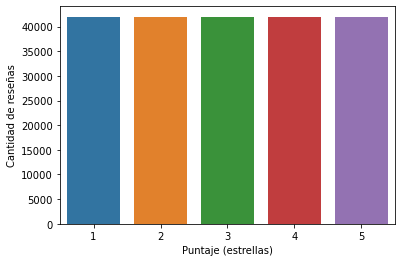

In [7]:
sns.countplot(x = 'stars', data = df_amazon)
plt.ylabel('Cantidad de reseñas')
plt.xlabel('Puntaje (estrellas)')

plt.show()

In [8]:
print('Existen',str(len(df_amazon['product_category'].unique())),'categorías únicas en el presente dataset')

Existen 30 categorías únicas en el presente dataset


Podemos observar que predominan las reseñas de productos línea **hogar** e **inalámbricos**

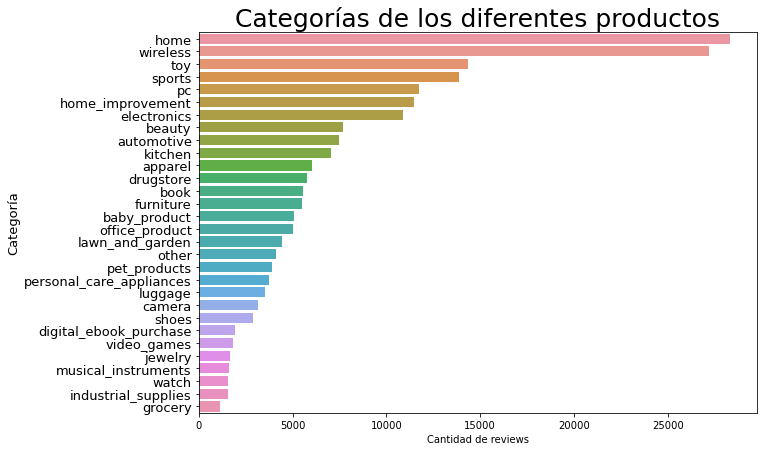

In [9]:
plt.figure(figsize = (10,7))

sns.countplot(y = 'product_category', 
              data = df_amazon,  
              order = df_amazon.product_category.value_counts().index)
plt.ylabel('Categoría',size=13)
plt.xlabel('Cantidad de reviews')
plt.tick_params(axis='y', labelsize=13)
plt.title('Categorías de los diferentes productos', size=25)
plt.show()

## Preprocesamiento de las reseñas

In [10]:
df_amazon['review_entero'] = df_amazon['review_body']+ ' ' + df_amazon['review_title']
df_amazon.reset_index(inplace=True,drop=True)
df_amazon.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_entero
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Malisimo, muy grande demasiado aparatoso y mal..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No he recibido el pedido no la devolución No l...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,"Tengo que buscar otro sistema, este no funcion..."
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Utilicé las brocas de menor diámetro y se me d...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta su olor a viejo y aspecto malo No ...


En primer lugar, tokenizo la reseña. Esto es, separo las palabras en comas

Cargo las palabras comunes (stopwords) en español para luego filtrar las distintas 

In [11]:
stopwords = stopwords.words('spanish')

A través de la siguiente función proceso el texto de cada fila. Esto incluye:
- Tokenizado (separación de una secuencia de palabras en partes, almacenadas en una lista)
- Elimino comas y puntos
- Quito las <code>stopwords</code>. Estas son palabras que carecen de significado por sí solas, como preposiciones, artículos, conjunciones, pronombres, etc.

El objetivo de este preprocesamiento que reducirá el ruido del texto, eliminando las formas infleccionales y formas a veces derivacionalmente relacionadas a una base común*, es facilitar el posterior análisis de cada reseña

*"**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**


McNary, Dave. “Keanu Reeves, Alex Winter Returning for ‘Bill and Ted Face the Music.’” Variety, Penske Media Corporation, 8 May 2018, variety.com/2018/film/news/bill-and-ted-3-keanu-reeves-alex-winter-1202802946/.



In [12]:
nlp = stanza.Pipeline('es',processors='tokenize,mwt,pos,lemma')

2021-03-15 11:52:02 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-03-15 11:52:02 INFO: Use device: cpu
2021-03-15 11:52:02 INFO: Loading: tokenize
2021-03-15 11:52:02 INFO: Loading: mwt
2021-03-15 11:52:02 INFO: Loading: pos
2021-03-15 11:52:03 INFO: Loading: lemma
2021-03-15 11:52:03 INFO: Done loading processors!


In [13]:
def procesar(texto):
    palabras = []
    doc = nlp(texto)
    for sent in doc.sentences:
        for word in sent.words:
            palabras.append(word.lemma)
    palabras = list(filter(lambda x: x != "," and x != ".", palabras))
    palabras = [item for item in palabras if item not in stopwords]
    return palabras

In [14]:
df_amazon.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_entero
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Malisimo, muy grande demasiado aparatoso y mal..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No he recibido el pedido no la devolución No l...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,"Tengo que buscar otro sistema, este no funcion..."
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Utilicé las brocas de menor diámetro y se me d...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta su olor a viejo y aspecto malo No ...


In [17]:
#df_amazon['review_entero_tk'] = df_amazon.apply(lambda row: procesar(row['review_entero']), axis=1)
df_amazon

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_entero,review_entero_tk
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Malisimo, muy grande demasiado aparatoso y mal...","[malisimo, grande, demasiado, aparatoso, mal, ..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No he recibido el pedido no la devolución No l...,"[haber, recibir, pedido, devolución, haber, re..."
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,"Tengo que buscar otro sistema, este no funcion...","[tener, buscar, sistema, funcionar, bien, abra..."
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Utilicé las brocas de menor diámetro y se me d...,"[utilizar, broca, menor, diámetro, doblar, var..."
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta su olor a viejo y aspecto malo No ...,"[gustar, olor, viejo, aspecto, malo, gustar]"
...,...,...,...,...,...,...,...,...,...,...
209995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics,Mando funciona perfectamente y cumple con toda...,"[Mando, funcionar, perfectamente, cumplir, fun..."
209996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics,"Compré la batería con cierta reticencia, pero ...","[comprar, batería, cierto, reticencia, resulta..."
209997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel,Buena calidad. Satisfecha con la compra. Buena...,"[buen, calidad, satisfecho, compra, buen, cali..."
209998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy,Perfecto para el cumple de mi hijo Recomendado,"[Perfecto, cumplir, hijo, Recomendado]"


In [18]:
df_amazon.to_excel('Preprocesado.xlsx')

In [2]:
df_amazon = pd.read_excel('Preprocesado.xlsx').drop(columns='Unnamed: 0')

In [37]:
r_1e = df_amazon[df_amazon['stars']==1]
r_2e = df_amazon[df_amazon['stars']==2]
r_3e = df_amazon[df_amazon['stars']==3]
r_4e = df_amazon[df_amazon['stars']==4]
r_5e = df_amazon[df_amazon['stars']==5]

lista_1e = r_1e.review_entero_tk.tolist()
lista_2e = r_2e.review_entero_tk.tolist()
lista_3e = r_3e.review_entero_tk.tolist()
lista_4e = r_4e.review_entero_tk.tolist()
lista_5e = r_5e.review_entero_tk.tolist()

r_1et = []
r_2et = []
r_3et = []
r_4et = []
r_5et = []

for i in lista_1e:
    i = nltk.RegexpTokenizer('\w+').tokenize(i)
    r_1et.append(i)

for i in lista_2e:
    i = nltk.RegexpTokenizer('\w+').tokenize(i)
    r_2et.append(i)

for i in lista_3e:
    i = nltk.RegexpTokenizer('\w+').tokenize(i)
    r_3et.append(i)

for i in lista_4e:
    i = nltk.RegexpTokenizer('\w+').tokenize(i)
    r_4et.append(i)

for i in lista_5e:
    i = nltk.RegexpTokenizer('\w+').tokenize(i)
    r_5et.append(i)

    
# Paso todos los elementos a una lista única
r_1et = list(itertools.chain(*r_1et))
r_2et = list(itertools.chain(*r_2et))
r_3et = list(itertools.chain(*r_3et))
r_4et = list(itertools.chain(*r_4et))
r_5et = list(itertools.chain(*r_5et))

word_freq1 = Counter(r_1et)
word_freq2 = Counter(r_2et)
word_freq3 = Counter(r_3et)
word_freq4 = Counter(r_4et)
word_freq5 = Counter(r_5et)

common_words_1s = word_freq1.most_common()
common_words_2s = word_freq2.most_common()
common_words_3s = word_freq3.most_common()
common_words_4s = word_freq4.most_common()
common_words_5s = word_freq5.most_common()

print('Lista de palabras más comunes para críticas de 1 estrella')
df_r_1s = pd.DataFrame(common_words_1s, columns = ['Words', 'Frequency'])
print(df_r_1s.head(5))
print('-------------')

print('Lista de palabras más comunes para críticas de 2 estrellas')
df_r_2s = pd.DataFrame(common_words_2s, columns = ['Words', 'Frequency'])
print(df_r_2s.head(5))
print('-------------')

print('Lista de palabras más comunes para críticas de 3 estrellas')
df_r_3s = pd.DataFrame(common_words_3s, columns = ['Words', 'Frequency'])
print(df_r_3s.head(5))
print('-------------')

print('Lista de palabras más comunes para críticas de 4 estrellas')
df_r_4s = pd.DataFrame(common_words_4s, columns = ['Words', 'Frequency'])
print(df_r_4s.head(5))
print('-------------')

print('Lista de palabras más comunes para críticas de 5 estrellas')
df_r_5s = pd.DataFrame(common_words_5s, columns = ['Words', 'Frequency'])
print(df_r_5s.head(5))

Lista de palabras más comunes para críticas de 1 estrella
      Words  Frequency
0       ser      30121
1     haber      28395
2    llegar      12340
3     tener      11288
4  producto       9101
-------------
Lista de palabras más comunes para críticas de 2 estrellas
     Words  Frequency
0      ser      43637
1    haber      22040
2    tener      14491
3     bien      11697
4  calidad       8977
-------------
Lista de palabras más comunes para críticas de 3 estrellas
   Words  Frequency
0    ser      44551
1   bien      18435
2  haber      16310
3  tener      13782
4   buen      10789
-------------
Lista de palabras más comunes para críticas de 4 estrellas
   Words  Frequency
0    ser      37995
1   buen      21297
2   bien      19142
3  haber      13117
4  tener      11847
-------------
Lista de palabras más comunes para críticas de 5 estrellas
     Words  Frequency
0      ser      31325
1     buen      21518
2    haber      12923
3  calidad      12045
4     bien      11849


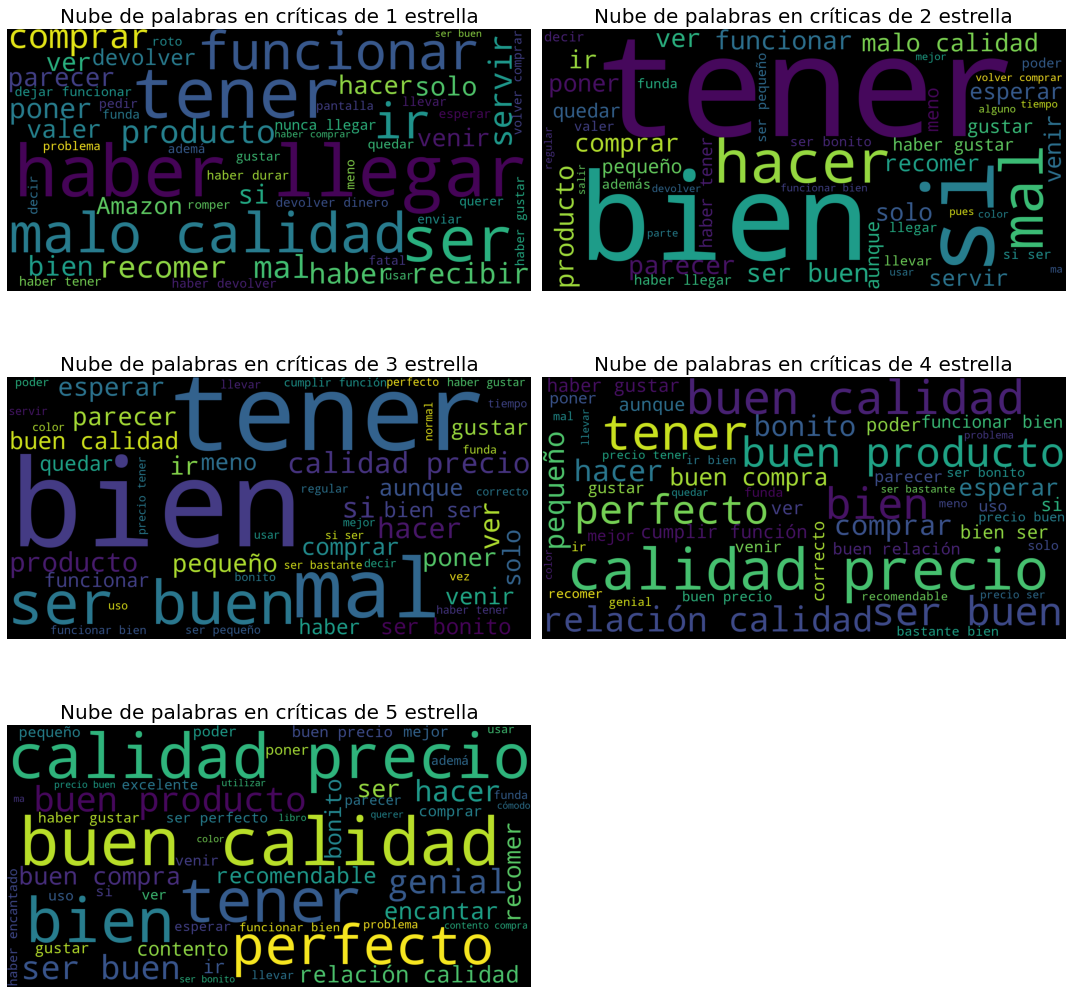

In [42]:
plt.figure(figsize=(15,15))

plt.subplot(321)
u_string=(" ").join(r_1et)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 1 estrellas', fontsize=20)

plt.subplot(322)
u_string2=(" ").join(r_2et)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string2)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 2 estrellas', fontsize=20)

plt.subplot(323)
u_string3=(" ").join(r_3et)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string3)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 3 estrellas', fontsize=20)

plt.subplot(324)
u_string4=(" ").join(r_4et)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string4)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 4 estrellas', fontsize=20)

plt.subplot(325)
u_string5=(" ").join(r_5et)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string5)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 5 estrellas', fontsize=20)

plt.tight_layout()
plt.show()